In [1]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!


import tf_memory_limit
from keras.models import load_model 
import tensorflow as tf

import numpy as np
import matplotlib.pylab as plt 
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm
import bisect
import pandas

import sequence
import train_TFmodel
import eval_TFmodel
import ctcfgen

Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [14]:
# get the generator
gen = ctcfgen.CTCFGeneratorhdf5('/home/kal/TF_models/seq_only/seq_classifier/ctcfgen_data.hdf5')
g = gen.pairgen(mode='val')

In [15]:
# get the model
sig = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/20170919_sigmoid_model/')
pwm_model = load_model('/home/kal/TF_models/seq_only/seq_classifier/pwm_frozen/final_model.hdf5')

In [16]:
# predict on test sequences and make a p-r and p-r gain curve
true_labels = list()
sig_preds = list()
pwm_preds = list()
pwmml_preds = list()
for i in tqdm(range(1000)):
    batch, labels = next(g)
    true_labels.append(labels)
    sig_preds.append(sig.model.predict(batch))
    pwmml_preds.append(pwm_model.predict(batch))
    for onehot in batch:
        seq = sequence.Sequence(onehot)
        pwm_preds.append(seq.find_pwm()[2])
    
true_labels = np.asarray(true_labels).flatten().tolist()
sig_preds = np.asarray(sig_preds).flatten().tolist()
pwmml_preds = np.asarray(pwmml_preds).flatten().tolist()
pwm_preds = np.asarray(pwm_preds).flatten().tolist()

100%|██████████| 1000/1000 [00:29<00:00, 34.40it/s]


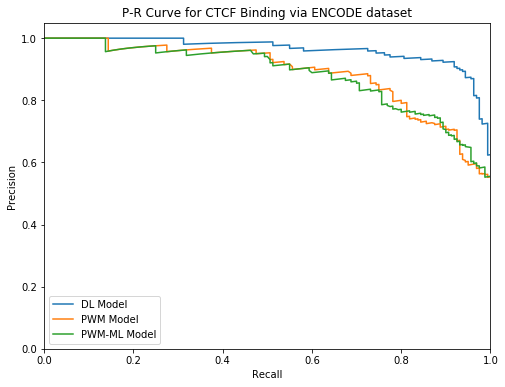

In [6]:
#p-r curve
sig_p, sig_r, sig_t = precision_recall_curve(true_labels, sig_preds, pos_label=1)
ml_p, ml_r, ml_t = precision_recall_curve(true_labels, pwmml_preds, pos_label=1)
pwm_p, pwm_r, pwm_t = precision_recall_curve(true_labels, pwm_preds, pos_label=1)

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve for CTCF Binding via ENCODE dataset')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(sig_r, sig_p, label='DL Model')
plt.plot(pwm_r, pwm_p, label='PWM Model')
plt.plot(ml_r, ml_p, label='PWM-ML Model')
plt.legend()
plt.show()

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars


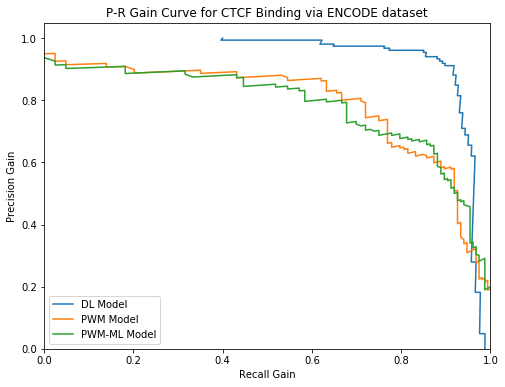

In [7]:
#p-r gain gurve
# we consider only p/r value between prop_pos and 1
prop_pos = sum(true_labels)/len(true_labels)

sig_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_p]
sig_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_r]
ml_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in ml_p]
ml_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in ml_r]
pwm_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_p]
pwm_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_r]

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Gain Curve for CTCF Binding via ENCODE dataset')
plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')
plt.plot(sig_pgain, sig_rgain, label='DL Model')
plt.plot(pwm_rgain, pwm_pgain, label='PWM Model')
plt.plot(ml_rgain, ml_pgain, label='PWM-ML Model')
plt.legend()
plt.show()

In [8]:
# predict on atac sequences from k562 and make a p-r and p-r gain curve
bed_path = '/home/kal/TF_models/data/K562_atac_peaks/final_atac.bed'
peaks = pandas.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf_label . . '.split()

In [9]:
# get the pwm and model predictions


In [10]:
layer_dict = dict([(layer.name, layer) for layer in pwm_model.layers])
print(layer_dict.keys())

dict_keys(['lambda_3', 'stackmax', 'input_3', 'conv1d_3'])


In [11]:
weights = sequence.Sequence(layer_dict['conv1d_1'].get_weights()[0])
weights.logo()

KeyError: 'conv1d_1'

In [ ]:
weights = layer_dict['conv1d_1'].get_weights()
print(weights[0][0])